# Vehicle Detection  

## Import libraries

In [1]:
# Include statements so Python modules are always reloaded.
# Speeds debugging and iteration
%load_ext autoreload
%autoreload 2


In [36]:
# Import modules for use within Jupyter workspace

import glob
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

In [180]:
#from helperfunctions import *
import helperfunctions as hf
import lesson_functions as lf

## Get paths to images and prepare to read them in

In [5]:
car_path = '/Users/blakejacquot/Desktop/temp/training_images/vehicles'
notcar_path = '/Users/blakejacquot/Desktop/temp/training_images/non-vehicles'

cars, notcars = hf.get_car_notcar_paths(car_path, notcar_path, verbose = True)

Number of car images =  8792
Number of not car images =  8968
Random car path =  /Users/blakejacquot/Desktop/temp/training_images/vehicles/GTI_Far/image0870.png
Random not car path =  /Users/blakejacquot/Desktop/temp/training_images/non-vehicles/Extras/extra2846.png


Mean, min, max of an image 0.439036 0.054902 1.0


## Explore histogram of gradients (HOG) features

In [10]:
# Define HOG parameters
orient = 9 # HOG orientations. 6 to 12.
pix_per_cell = 8  #HOG pixels per cell
cell_per_block = 2 # HOG cells per block. Normalization happens over block.
color_conv = 'RGB2YCrCb'

### Test HOG with random image

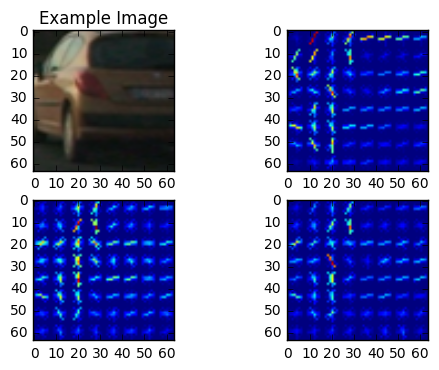

HOG features native <class 'numpy.ndarray'> (1764,)


In [11]:
# Generate a random index to look at a car image
ind_car = np.random.randint(0, len(cars))
rand_car = cars[random.randint(1, len(cars))]

# Read in the image
img_car = mpimg.imread(rand_car)

ctrans_tosearch = lf.convert_color(img_car, conv=color_conv)

ch1 = ctrans_tosearch[:,:,0]
ch2 = ctrans_tosearch[:,:,1]
ch3 = ctrans_tosearch[:,:,2]

# Compute individual channel HOG features for the entire image
hog1feat, hog1img = lf.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog2feat, hog2img = lf.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog3feat, hog3img = lf.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot images
fig = plt.figure()
plt.subplot(221)
plt.imshow(img_car)
plt.title('Example Image')
plt.subplot(222)
plt.imshow(hog1img)
plt.subplot(223)
plt.imshow(hog2img)
plt.subplot(224)
plt.imshow(hog3img)
plt.show()

print('HOG features native', type(hog1feat), np.shape(hog1feat))
#HOG_features_flattened = features_car.flatten()
#print('HOG features flattened', HOG_features_flattened)
#print('HOG features stats', max(HOG_features_flattened), min(HOG_features_flattened), len(HOG_features_flattened), np.median(HOG_features_flattened))


## Define color histogram and spatial features parameters

In [18]:
# Histogram and spatial features parameters
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)
channel = 'ALL'

# HOG parameter
orient = 9 # HOG orientations. 6 to 12.
pix_per_cell = 8  #HOG pixels per cell
cell_per_block = 2 # HOG cells per block. Normalization happens over block.
hog_channel = 'ALL'

imgs = [rand_car]

In [20]:
features = lf.extract_features(imgs, color_space=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

print('Shape of feature vector', np.shape(features))

Shape of feature vector (1, 8460)


In [22]:
car_features = lf.extract_features(cars, color_space=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

notcar_features = lf.extract_features(notcars, color_space=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

print('car_features shape ', np.shape(car_features))
print('notcar_features shape ', np.shape(notcar_features))

car_features shape  (8792, 8460)
notcar_features shape  (8968, 8460)


In [28]:
svc, X_scaler = hf.train_model(car_features, notcar_features)

X shape (17760, 8460)
scaled_X shape (17760, 8460)
y (17760,)
X_train  (14208, 8460)
Feature vector length: 8460
6.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
0.00091 Seconds to predict 10 labels with SVC
<class 'sklearn.svm.classes.LinearSVC'> <class 'sklearn.preprocessing.data.StandardScaler'>


In [29]:
print(type(svc))
print(type(X_scaler))

<class 'sklearn.svm.classes.LinearSVC'>
<class 'sklearn.preprocessing.data.StandardScaler'>


In [31]:
# Save data to file so we don't have to redo training

import pickle

data = {'svc': svc,
         'X_scaler': X_scaler
        }

output = open('data.pkl', 'wb')
pickle.dump(data, output)
output.close()


In [32]:
# Read in data

pkl_file = open('data.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

svc = data['svc']
X_scaler = data['X_scaler']


## Work with jpg files supplied by Udacity

In [38]:
# Get paths to test images
testimg_path = os.path.join('.', 'test_images/')
testimgs = []
testimgs= glob.glob(os.path.join(testimg_path, '*.jpg'))
print(testimgs)

['./test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']


## Explore sliding window search

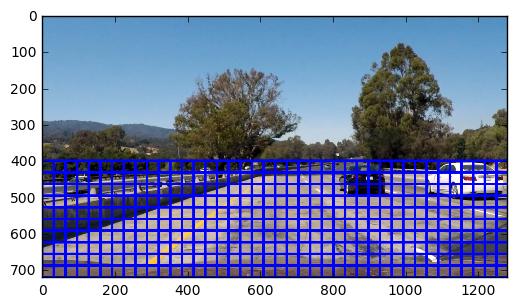

In [148]:
x_start = None
x_stop = None
y_start = 400
y_stop = None
xy_window=(64, 64)
xy_overlap=(0.5, 0.5)

image = mpimg.imread(testimgs[0])

windows = lf.slide_window(image, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_stop], 
                    xy_window=xy_window, xy_overlap=xy_overlap)
                       
window_img = lf.draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

image = mpimg.imread(testimgs[1])

windows = lf.slide_window(image, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_stop], 
                    xy_window=xy_window, xy_overlap=xy_overlap)
                       
window_img = lf.draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

image = mpimg.imread(testimgs[1])

windows = lf.slide_window(image, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_stop], 
                    xy_window=xy_window, xy_overlap=xy_overlap)
                       
window_img = lf.draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

## Try vehicle detection on jpg images

In [168]:
# Reiterate variables for good measure

cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(32, 32) # (32,32), (16,16)
hist_bins=32
hist_range=(0, 256)
channel = 'ALL'

# HOG parameter
orient = 9 # HOG orientations. 6 to 12.
pix_per_cell = 8  #HOG pixels per cell
cell_per_block = 2 # HOG cells per block. Normalization happens over block.
hog_channel = 'ALL'

x_start = None
x_stop = None
y_start = 400
y_stop = 656
xy_window= (128, 128) #(128, 128)
xy_overlap=(0.5, 0.5) #(0.5, 0.5)

spatial_feat = True
hist_feat = True
hog_feat = True

scale = 1.5

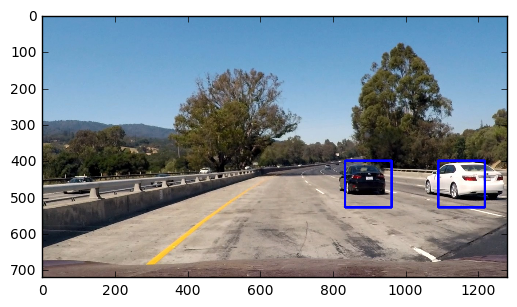

Hot windows [((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


In [169]:
image = mpimg.imread(testimgs[0])
draw_image = np.copy(image)

image = image.astype(np.float32)/255


windows = lf.slide_window(image, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_stop], 
                    xy_window=xy_window, xy_overlap=xy_overlap)

hot_windows = lf.search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = lf.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

print('Hot windows', hot_windows)


In [170]:
# Try HOG subsampling

scale = 1.5

image = mpimg.imread(testimgs[0])


# Expects to receive jpeg file on scale of 0 to 1
out_img, window_list = lf.find_cars(image, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

print(window_list)




[((48, 424), (144, 520)), ((744, 400), (840, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((840, 424), (936, 520)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520))]


## Add heatmap

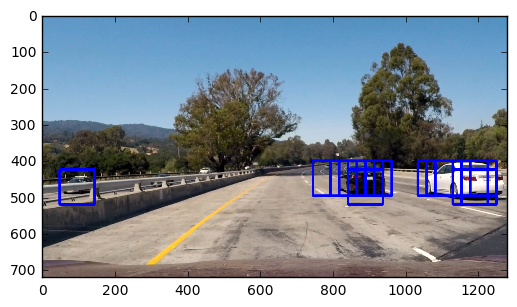

hot_windows [((48, 424), (144, 520)), ((744, 400), (840, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((840, 424), (936, 520)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520))]
labels (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


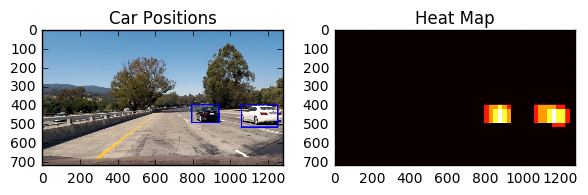

In [176]:
threshold = 1

from scipy.ndimage.measurements import label

image = mpimg.imread(testimgs[0])
#image = image.astype(np.float32)/255


scale = 1.5

out_img, windows = lf.find_cars(image, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#xy_window = (128, 128)
#out_img, windows2 = lf.find_cars(image, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)



hot_windows = lf.search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       


window_img = lf.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()


print('hot_windows', hot_windows)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = lf.add_heat(heat,hot_windows)
heat = lf.apply_threshold(heat,threshold)
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

print('labels', labels)

#window_img = lf.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

draw_img = lf.draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.show()

## Process all jpegs

1
./output_images/test1.png


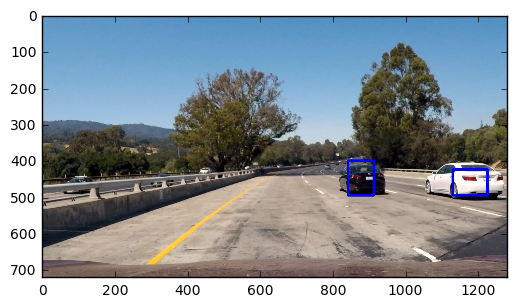

2
./output_images/test2.png


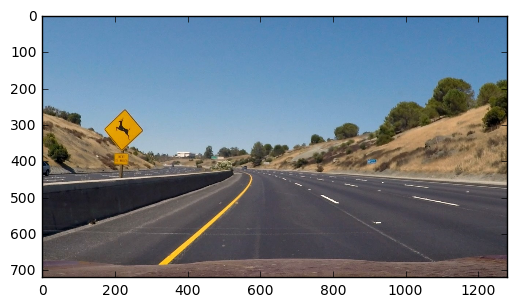

3
./output_images/test3.png


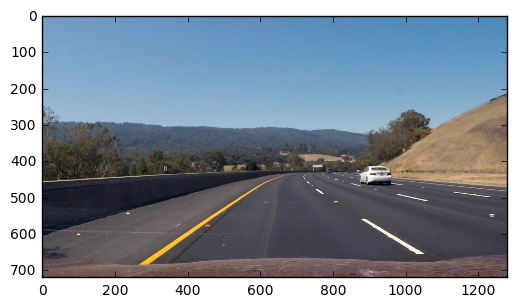

4
./output_images/test4.png


5
./output_images/test5.png


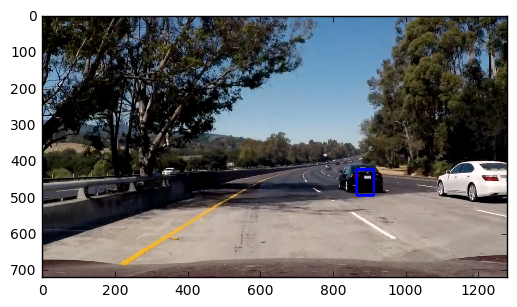

6
./output_images/test6.png


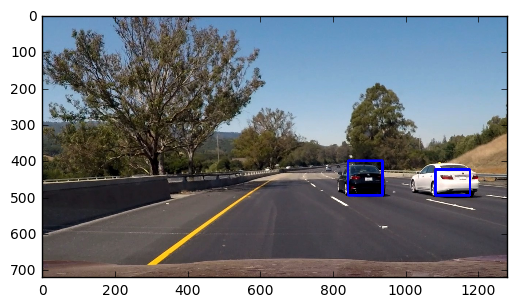

In [177]:
for img in testimgs:
    image = mpimg.imread(img)
    #image = image.astype(np.float32)/255

    out_img, windows = lf.find_cars(image, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    hot_windows = lf.search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = lf.add_heat(heat,hot_windows)
    heat = lf.apply_threshold(heat,3)
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)

    draw_img = lf.draw_labeled_bboxes(np.copy(image), labels)
    
    imgnum = img[-5:-4]
    print(imgnum)
    savename = 'test' + str(imgnum) + '.png'
    savepath = os.path.join('.', 'output_images', savename)
    print(savepath)
    mpimg.imsave(savepath, draw_img)
    
    plt.imshow(draw_img)
    plt.show()


## Test on video

In [184]:
video_path = os.path.join('.', 'test_video.mp4')
output_path = os.path.join('.', 'test_video_out.mp4')

hf.process_video(video_path, output_path)

[MoviePy] >>>> Building video ./test_video_out.mp4
[MoviePy] Writing video ./test_video_out.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  3.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out.mp4 



In [185]:
video_path = os.path.join('.', 'project_video.mp4')
output_path = os.path.join('.', 'project_video_out.mp4')

hf.process_video(video_path, output_path)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [07:07<00:00,  2.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

